### Import

In [1029]:
import numpy as np
import sympy as sp

import matplotlib
import matplotlib.pyplot as plt 
matplotlib.use('Agg')

from sympy import Matrix, init_printing

import qiskit
from qiskit import *

# Representing Data
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_bloch_multivector

# Monitor Job on Real Machine
from qiskit.tools.monitor import job_monitor

from functools import reduce # perform sucessive tensor product

# Calculating cost
from sklearn.metrics import mean_squared_error

# Generating random unitary matrix
from scipy.stats import unitary_group

# Measure run time
import time

# Almost Equal
from numpy.testing import assert_almost_equal as aae

### Useful Resources

###### Helpful Linear Algebra Matrices and Methods

In [645]:
# Matrices
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
H = 1/np.sqrt(2)*np.array([[1, 1], [1, -1]])
S = np.array([[1, 0], [0, 1j]])

CX = np.array([[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0]])

# Eigenvectors of Pauli Matrices
zero = np.array([[1], [0]]) # Z plus basis state
one = np.array([[0], [1]]) # Z plus basis state

plus = np.array([[1], [1]])/np.sqrt(2) # X plus basis state
minus = np.array([[1], [-1]])/np.sqrt(2) # X minus basis state

up = np.array([[1], [1j]])/np.sqrt(2) # Y plus basis state
down = np.array([[1], [-1j]])/np.sqrt(2) # Y plus basis state

# Bell States
B00 = np.array([[1], [0], [0], [1]])/np.sqrt(2) # Bell of 00
B01 = np.array([[1], [0], [0], [-1]])/np.sqrt(2) # Bell of 01
B10 = np.array([[0], [1], [1], [0]])/np.sqrt(2) # Bell of 10
B11 = np.array([[0], [-1], [1], [0]])/np.sqrt(2) # Bell of 11

# Rn Matrix Function
Rx = lambda theta: np.array([[np.cos(theta/2), -1j*np.sin(theta/2)], [-1j*np.sin(theta/2), np.cos(theta/2)]])
Ry = lambda theta: np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])
Rz = lambda theta: np.array([[np.exp(-1j*theta/2), 0], [0, np.exp(1j*theta/2)]])

# Tensor Product of 2+ matrices/ vectors
tensor = lambda *initial_state: reduce(lambda x, y: np.kron(x, y), initial_state)

# Matrix Multiplicaton of 2+ matrices / vectors
mat_mul = lambda *initial_state: reduce(lambda x, y: np.dot(x, y), initial_state)

###### CU Matrix

In [625]:
def cu_matrix(no_qubits, control, target, U, little_edian = True):
    
    """
    Manually build the unitary matrix for non-adjacent CX gates
    
    Parameters:
    -----------
    no_qubits: int
        Number of qubits in the circuit
    control: int
        Index of the control qubit (1st qubit is index 0)
    target: int
        Index of the target qubit (1st qubit is index 0)
    U: ndarray
        Target unitary matrix
    edian: bool (True: qiskit convention)
        Qubits order convention
        
    Returns:
    --------
    cx_out:
        Unitary matrix for CU gate
    """
    
    left = [I]*no_qubits
    right = [I]*no_qubits
    
    left[control] = np.dot(zero, zero.T)
    right[control] = np.dot(one, one.T)

    right[target] = U

    if little_edian:
        cx_out = tensor(*reversed(left)) + tensor(*reversed(right))
    else:
        cx_out = tensor(*left) + tensor(*right)
    
    # This returns a unitary in qiskit 'little eddian', to switch back, simply switch the target for control
          
    return cx_out

###### View Matrix

In [760]:
def view(mat, rounding = 10):
    display(Matrix(np.round(mat, rounding)))

###### Get Unitary/StateVector Function

In [9]:
def get(circ, types = 'unitary', nice = True):
    
    """
    This function return the statevector or the unitary of the inputted circuit
    
    Parameters:
    -----------
    circ: QuantumCircuit
        Inputted circuit without measurement gate
    types: str ('unitary')
        Get 'unitary' or 'statevector' option
    nice: bool
        Display the result nicely option or just return unitary/statevector as ndarray
        
    Returns:
    --------
    out: ndarray
        Outputted unitary of statevector
        
    """
    
    if types == 'statevector':
        backend = BasicAer.get_backend('statevector_simulator')
        out = execute(circ, backend).result().get_statevector()
    else: 
        backend = BasicAer.get_backend('unitary_simulator')
        out = execute(circ, backend).result().get_unitary()
        
    if nice:
        display(Matrix(np.round(out, 10))) 
    else:
        return out

###### Draw Circuit

In [1020]:
def milk(circ):
    return circ.draw('mpl')

###### Convert ndarray to list

In [11]:
to_list = lambda array: list(np.squeeze(array))

###### Displaying Output

In [12]:
def sim(circ, visual = 'hist'):
    
    """
    Displaying output of quantum circuit
    
    Parameters:
    -----------
    circ: QuantumCircuit
        QuantumCircuit with or without measurement gates
    visual: str ('hist')
        'hist' (counts on histogram) or 'bloch' (statevectors on Bloch sphere) or None (get counts only)
        
    Returns:
    --------
    counts: dict
        Counts of each CBS state
    """
    
    # Simulate circuit and display counts on a histogram
    if visual == 'hist':
        simulator = Aer.get_backend('qasm_simulator')
        results = execute(circ, simulator).result()
        counts = results.get_counts(circ)
        plot_histogram(counts)
        
        return counts
        
    # Get the statevector and display on a Bloch sphere
    elif visual == 'bloch':
        backend = BasicAer.get_backend('statevector_simulator')
        statevector = execute(circ, backend).result().get_statevector()
        get(circ)
        plot_bloch_multivector(statevector)
        
    # Just get counts
    else:
        simulator = Aer.get_backend('qasm_simulator')
        results = execute(circ, simulator).result()
        counts = results.get_counts(circ)
        
        return counts

#### Draw Transpiled Circuit

In [1030]:
def dtp(circ, print_details = True, visual = True, return_values = False):
    
    """
    Draw and/or return information about the transpiled circuit
    
    Parameters:
    -----------
    circ: QuantumCircuit
        QuantumCircuit to br transpiled
    print_details: bool (True)
        Print the number of u3 and cx gates used
    visual: bool (True)
        Show the transpiled circuit
    return_values: bool (True)
        Return the number of u3 and cx gates used
        
    Returns:
    --------
    no_cx: int
        Number of cx gates used
    no_u3: int
        Number of u3 gates used
    
    """
    
    # Transpile Circuit
    circ = transpile(circ, basis_gates=['u3', 'cx'], optimization_level=3)

    # Count operations
    gates = circ.count_ops()

    # Compute cost
    try:
        no_u3 = gates['u3']
    except:
        no_u3 = 0
        
    try:
        no_cx = gates['cx']
    except:
        no_cx = 0
    
    cost = no_u3 + 10*no_cx

    if print_details:
        # Print Circuit Details
        print(f'cx: {no_cx}')

        print(f'u3: {no_u3}')
        print(f'Total cost: {cost}')
    
    if visual:
        return circ.draw('mpl')
    
    if return_values:
        return no_cx, no_u3

#### Angles From Statevector

In [14]:
def angles_from_statevectors(output_statevector):
    
    """
    Calculate correct x, y rotation angles from an arbitrary output statevector
    
    Paramters:
    ----------
    output_statevector: ndarray
        Desired output state
        
    Returns:
    --------
    phi: float
        Angle to rotate about the y-axis [0, 2pi)
    theta: float
        Angle to rotate about the x-axis [0, 2pi)
    
    """
    
    # Extract the components
    x, z = output_statevector.real
    y, w = output_statevector.imag
    
    # Calculate the correct angles
    phi = 2*np.arctan2(z,x)[0]
    theta = 2*np.arctan2(y,z)[0]
    
    print(f'phi: {phi}')
    print(f'theta: {theta}')
    
    return phi, theta

### $C^nX$ Unitary

## C = 2

### Toffoli Gate (C2X)

#### Circuit

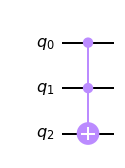

In [124]:
circ = QuantumCircuit(3)
circ.ccx(0, 1, 2)

milk(circ)

#### Cost

cx: 6
u3: 8
Total cost: 68


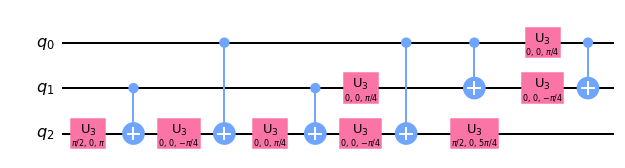

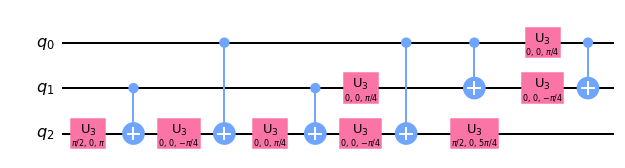

In [128]:
dtp(circ)

### Pseudo-Toffoli Gate (p-C2X)

#### Circuit

The Pseudo-Toffoli gate have a very similar unitary. The only difference is the negative phase when the input is $|110\rangle$.

In [125]:
def C2X(circ, control_qubit1, control_qubit2, target_qubit):
    
    circ.ch(control_qubit1, target_qubit)
    circ.cz(control_qubit2, target_qubit)
    circ.ch(control_qubit1, target_qubit)
    
    return circ

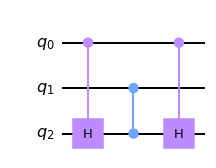

In [126]:
circ = QuantumCircuit(3)

circ = C2X(circ, 0, 1, 2)

milk(circ)

In [127]:
get(circ)

Matrix([
[1.0,   0,   0,   0,   0,   0,    0,   0],
[  0, 1.0,   0,   0,   0,   0,    0,   0],
[  0,   0, 1.0,   0,   0,   0,    0,   0],
[  0,   0,   0,   0,   0,   0,    0, 1.0],
[  0,   0,   0,   0, 1.0,   0,    0,   0],
[  0,   0,   0,   0,   0, 1.0,    0,   0],
[  0,   0,   0,   0,   0,   0, -1.0,   0],
[  0,   0,   0, 1.0,   0,   0,    0,   0]])

#### Cost

The pseudo-Toffoli gate is half as expensive as the normal Toffoli gate, with the drawback of a single negative phase difference.

cx: 3
u3: 4
Total cost: 34


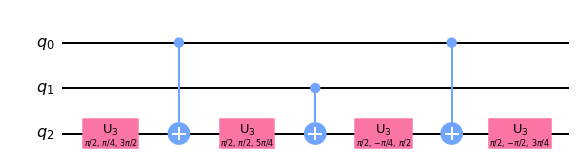

In [128]:
dtp(circ)

### C3X Gate

First we start of with the classic implementation using MCT gate. This uses 4 qubits

#### Circuit

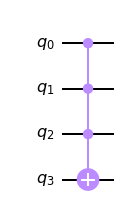

In [78]:
circ = QuantumCircuit(4)
circ.mct([0, 1, 2] , 3)
milk(circ)

#### Cost

In [79]:
dtp(circ, False)

cx: 20
u3: 22
Total cost: 222


Another possible implementation is a little bit less expensive in CXs but uses 5 qubits

#### Circuit

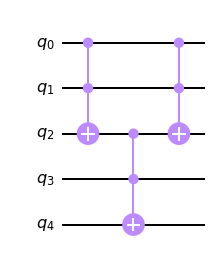

In [80]:
circ = QuantumCircuit(5)
circ.ccx(0, 1, 2)
circ.ccx(2, 3, 4)
circ.ccx(0, 1, 2)

milk(circ)

#### Cost

In [81]:
dtp(circ, False)

cx: 18
u3: 24
Total cost: 204


### p-C3X Gate

The first approach aims to mirror the MCT gate above and uses 4 qubits

In [1192]:
# Controlled-S
def CS(n):
    circ = QuantumCircuit(1)
    circ.s(0)
    circ = circ.control(n)
    
    return circ

def CS_dagger(n):
    circ = QuantumCircuit(1)
    circ.sdg(0)
    circ = circ.control(n)
    
    return circ

def CCZ(circ, c1, c2, t):
    circ = circ.compose(CS(1), [c2, t])
    circ.cx(c1, c2)
    circ = circ.compose(CS_dagger(1), [c2, t])
    circ.cx(c1, c2)
    circ = circ.compose(CS(1), [c1, t])

    return circ

def C3X(circ, c1, c2, c3, t):

    circ.ch(c1, t)

    circ = CCZ(circ, c2, c3, t)

    circ.ch(c1, t)

    return circ

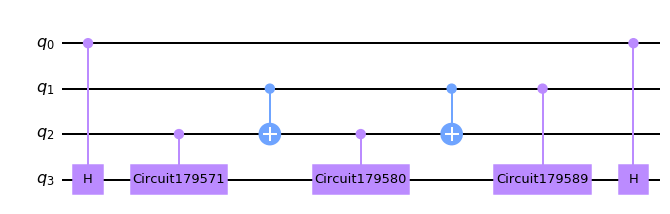

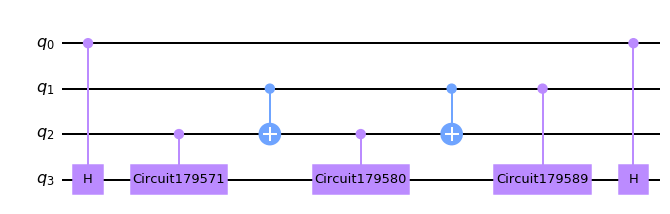

In [1193]:
circ = QuantumCircuit(4)
circ = C3X(circ, 0, 1, 2, 3)

milk(circ)

In [1135]:
dtp(circ, visual = False)

cx: 10
u3: 13
Total cost: 113


The second approach uses 1 ancilla but is less expensive in terms of CXs

#### Circuit

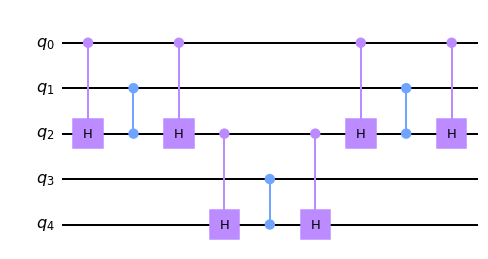

In [122]:
circ = QuantumCircuit(5)

circ = C2X(circ, 0, 1, 2)
#circ.ccx(0, 1, 2)

circ = C2X(circ, 2, 3, 4)
#circ.ccx(2, 3, 4)

circ = C2X(circ, 0, 1, 2)
#circ.ccx(0, 1, 2)

milk(circ)

#### Cost

In [123]:
dtp(circ, False)

cx: 9
u3: 12
Total cost: 102


### C4X Gate

The first approach uses MCT gates

#### Circuit

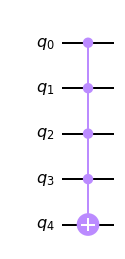

In [109]:
circ = QuantumCircuit(5)
circ.mct([0, 1, 2, 3] , 4)
milk(circ)

#### Cost

In [111]:
dtp(circ, False)

cx: 44
u3: 46
Total cost: 486


The second approach uses 2 ancillas but is less expensive in terms of CXs

#### Circuit

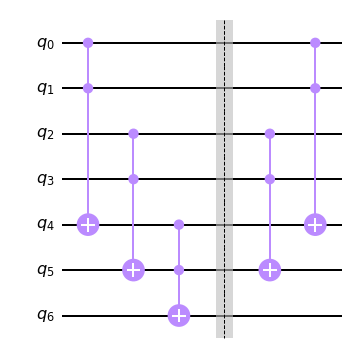

In [104]:
circ = QuantumCircuit(7)
circ.ccx(0, 1, 4)
circ.ccx(2, 3, 5)
circ.ccx(4, 5, 6)

# Reverse
circ.barrier()
circ.ccx(2, 3, 5)
circ.ccx(0, 1, 4)

milk(circ)

#### Cost

In [105]:
a = get(circ, nice = False)

dtp(circ, False)

cx: 30
u3: 40
Total cost: 340


### p-C4X

This uses the same architecture as above, with an $MCT(n-1)$ gate

#### Circuit

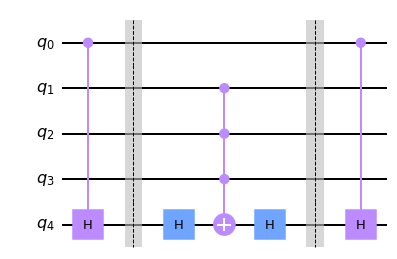

In [119]:
circ = QuantumCircuit(5)
circ.ch(0, 4)

circ.barrier()
circ.h(4)
circ.mct([1, 2, 3] , 4)
circ.h(4)
circ.barrier()
circ.ch(0, 4)

milk(circ)

#### Cost

In [120]:
dtp(circ, False)

cx: 22
u3: 25
Total cost: 245


#### Circuit

The second approach uses 2 ancillas but is less expensive in terms of CXs

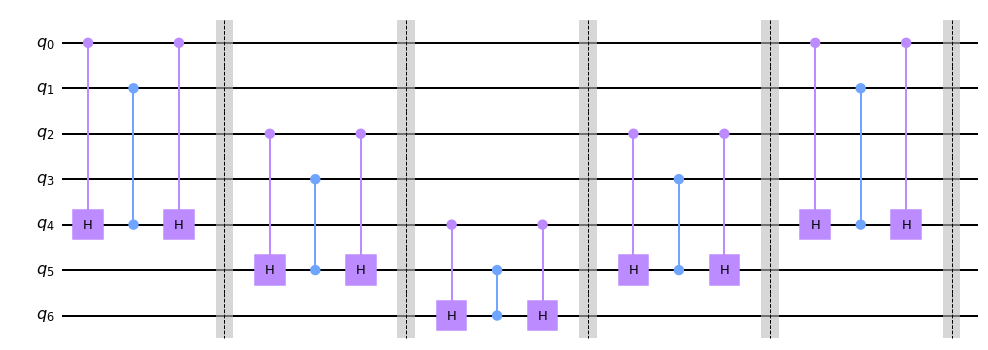

In [113]:
circ = QuantumCircuit(7)
circ = C2X(circ, 0, 1, 4)
circ.barrier()
circ = C2X(circ, 2, 3, 5)
circ.barrier()
circ = C2X(circ, 4, 5, 6)

# Reverse
circ.barrier()
circ = C2X(circ, 2, 3, 5)
circ.barrier()
circ = C2X(circ, 0, 1, 4)
circ.barrier()

milk(circ)

#### Cost

In [114]:
b = get(circ, nice = False)
dtp(circ, False)

cx: 15
u3: 20
Total cost: 170


### Discussions

So far we have seen that there are two methods for building n-Toffoli. Number $1$ uses MCT, with no acilla qubits, and number $2$ uses exclusively Toffoli gate with $1$ or more ancilla qubits.

For the pseudo-circuit, for approach $1$, up to $n = 3$, it is possible to decompose the CCZ into simple CX gates which makes reducing the cost possible. However, for $n > 3$, the best method so far is to use MCT with n-1 control gates and add on the $CH$ architecture. The cost reduced by this is a little bit more than $0.5$.

For approach number $2$, all the Toffoli gates are replaced with pseudo-C2X and the cost is strictly reduced to $0.5$

Now the discussion will continue in the linear algebra form. The first function generates the CnX gate. This can be used to check correctness of any proposed algorithms.

In [130]:
def CnX(n):
    
    """
    Return the unitary of the CnX gate
    
    Parameters:
    -----------
    n: int
        Number of control bits
    
    Returns:
    --------
    U: ndarray
    
    
    """

    # Build Identity
    size = 2**(n+1)
    U = np.identity(size)

    # Change up the controlled elements

    # 0
    U[int(size/2)-1, int(size/2)-1] = 0
    U[size-1, int(size/2)-1] = 1

    # 1
    U[size-1, size-1] = 0
    U[int(size/2)-1, size-1] = 1
    
    return U

### Proposed Architecture

1. Nested CH-CZ Architecture

#### 1. Nested CH-CZ architecture

##### a. Pseudo-C2X Core

Let's go through some examples of this. For the core, we use the pseudo-C2X. Note that the $CZ$ in the middle can be replaced by the $H-CX-H$ structure

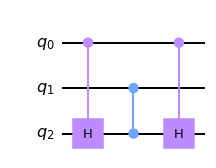

In [135]:
# Circuit

## n=2
circ = QuantumCircuit(3)
circ.ch(0, 2)
circ.cz(1, 2)
circ.ch(0, 2)

milk(circ)

In [136]:
# Unitary
get(circ)

Matrix([
[1.0,   0,   0,   0,   0,   0,    0,   0],
[  0, 1.0,   0,   0,   0,   0,    0,   0],
[  0,   0, 1.0,   0,   0,   0,    0,   0],
[  0,   0,   0,   0,   0,   0,    0, 1.0],
[  0,   0,   0,   0, 1.0,   0,    0,   0],
[  0,   0,   0,   0,   0, 1.0,    0,   0],
[  0,   0,   0,   0,   0,   0, -1.0,   0],
[  0,   0,   0, 1.0,   0,   0,    0,   0]])

Here we take the previous pseudo $C2X$ and add two Hadamard on both sides, and repeat the $CH$s. Recall that that $CH-Z-CH = \text{pseudo-}X$, and $HXH = \text{pseudo-}Z$

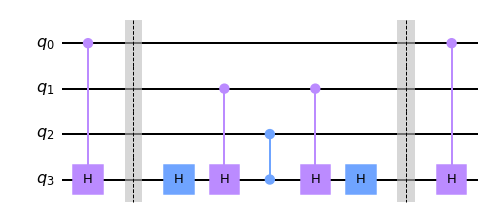

In [245]:
# Circuit

## n=3
circ = QuantumCircuit(4)

circ.ch(0, 3)

# pesudo-CCZ
circ.barrier()
circ.h(3)
circ.ch(1, 3)
circ.cz(2, 3)
circ.ch(1, 3)
circ.h(3)
circ.barrier()

circ.ch(0, 3)

milk(circ)

In [246]:
get(circ)

Matrix([
[1.0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,    0,   0],
[  0, 1.0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,    0,   0],
[  0,   0, 1.0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,    0,   0],
[  0,   0,   0, 1.0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,    0,   0],
[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 1.0,    0,    0,   0],
[  0,   0,   0,   0,   0, 1.0,   0,   0,   0,   0,   0,   0,   0,    0,    0,   0],
[  0,   0,   0,   0,   0,   0, 1.0,   0,   0,   0,   0,   0,   0,    0,    0,   0],
[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,    0, 1.0],
[  0,   0,   0,   0,   0,   0,   0,   0, 1.0,   0,   0,   0,   0,    0,    0,   0],
[  0,   0,   0,   0,   0,   0,   0,   0,   0, 1.0,   0,   0,   0,    0,    0,   0],
[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 1.0,   0,   0,    0,    0,   0],
[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 1.0,   0,  

Now we define a matrix to compare the accuracy of a proposed unitary. 

Let $A$ be the correct $CnX$ matrix and $B$ be a proposed unitary. Both matrices has dimension $(2^{n+1}, 2^{n+1})$, where $n$ is the number of control qubits.

The number of errors is defined as the number of non-zeros on the proposed unitary that is on a different position compared to the original matrix

$$acc = 1 - \frac{E}{2^{(n+1)}}$$ 

For example, despite the phase difference,

$$\begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \ \cong \ \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}$$

However, when the non-zero is in a different position

$$\begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \ \not\cong \ \begin{bmatrix} 1 & 1 \\ 0 & 0 \end{bmatrix}$$

In [875]:
acc = lambda n, a, b: np.sum(np.all(np.abs(a) == np.round(np.abs(b)), axis = 1)) / 2**(n+1)

Now we build a function that generates the general $CH-CZ$ architecture. First, we start off with building the visual qiskit circuit

In [1191]:
def nested_C2X(n):
    
    ### n has to minimum 2

    circ = QuantumCircuit(n+1)

    for i in range(n-1):
        circ.ch(i, n)
        circ.h(n)

    circ.cx(n-1, n)

    for i in reversed(range(n-1)): 
        circ.h(n)
        circ.ch(i, n)
        
    return circ

Matrix([
[1.0,   0,   0,   0,   0,   0,    0,   0],
[  0, 1.0,   0,   0,   0,   0,    0,   0],
[  0,   0, 1.0,   0,   0,   0,    0,   0],
[  0,   0,   0,   0,   0,   0,    0, 1.0],
[  0,   0,   0,   0, 1.0,   0,    0,   0],
[  0,   0,   0,   0,   0, 1.0,    0,   0],
[  0,   0,   0,   0,   0,   0, -1.0,   0],
[  0,   0,   0, 1.0,   0,   0,    0,   0]])

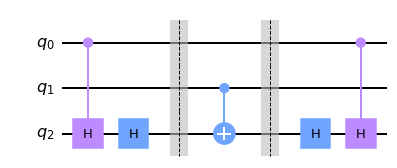

In [1039]:
circ= nested_C2X(2)
milk(circ)
get(circ)

Now we compare the unitary of this circuit to the correct $CnX$ unitary, from where we can find the accuracy

In [922]:
acc_list = []

for n in range(2, 11):

    a = CnX(n)

    b = get(nested_C2X(n), nice = False)

    acc_list.append(acc(n, a, b))

Plotting the accuracy as a function of control gates, we see that the accuracy is monotonic decreasing but it seems to asymptotes at 0.75 or $\frac{3}{4}$

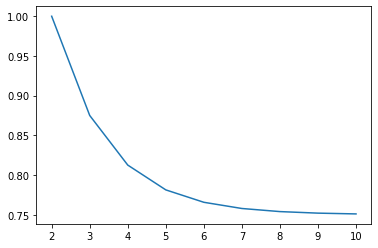

In [923]:
plt.plot(range(2, 11), acc_list)

In [910]:
acc_list

[1.0,
 0.875,
 0.8125,
 0.78125,
 0.765625,
 0.7578125,
 0.75390625,
 0.751953125,
 0.7509765625]

Now we can retreive the number of errors from the accuracy list

In [911]:
acc_list = np.array(acc_list)
(1 - acc_list) * 2**np.arange(3, 12)

array([  0.,   2.,   6.,  14.,  30.,  62., 126., 254., 510.])

We can express the number of errors as a sequence. We start at $s = 2$

$$a_s = 2^{s-1} - 2$$

And we can express the number of vectors in the matrix as another sequence

$$b_s = 2^{s+1}$$

As $s$ increases $\frac{a_s}{b_s}$ approaches $\frac{1}{4}$

$$\lim_{s\to \infty} = \frac{2^{s-1} - 2}{2^{s+1}} = \frac{2^{s-1}}{2^{s+1}} - \frac{2}{2^{s+1}} = 2^{(s-1-s-1)} - 0 = 2^{-2} = \frac{1}{4}$$

##### b. Pseudo-C3X Core

Now instead, if we set the core circuit as the pseudo-C3X built above.

In [1189]:
def nested_C3X(n):
    
    ## n has minimum of 3

    circ = QuantumCircuit(n+1)

    for i in range(n-3):
        circ.ch(i, n)
        circ.h(n)

    circ = C3X(circ, n-3, n-2, n-1, n)

    for i in reversed(range(n-3)): 
        circ.h(n)
        circ.ch(i, n)
        
    return circ

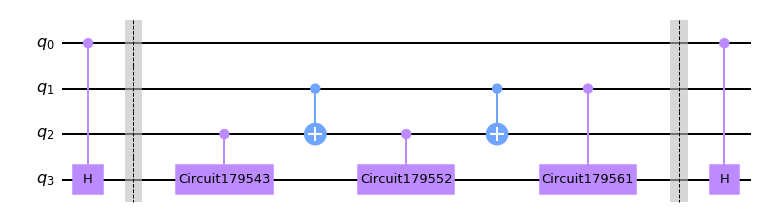

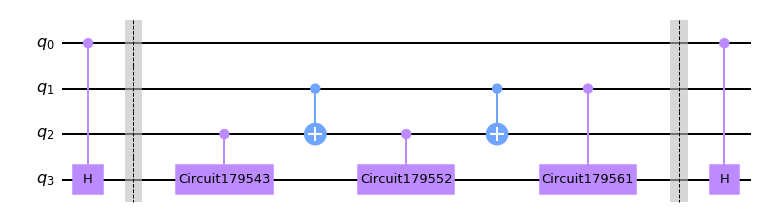

In [1190]:
circ = nested_C3X(3)

milk(circ)

We again calculate the accuracy at different value of $n$.

In [924]:
acc_list = []

for n in range(3, 11):

    a = CnX(n)

    b = get(nested_C3X(n), nice = False)

    acc_list.append(acc(n, a, b))

In [925]:
acc_list

[1.0,
 0.9375,
 0.90625,
 0.890625,
 0.8828125,
 0.87890625,
 0.876953125,
 0.8759765625]

As a function of the number of control gates, the graph seems to asymptote at $\frac{7}{8}$

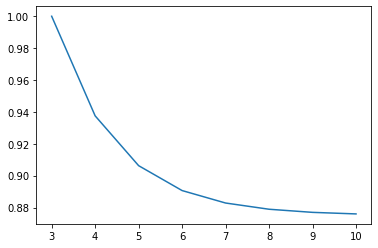

In [926]:
plt.plot(range(3, 11), acc_list)

Calculate the number of errors

In [927]:
acc_list = np.array(acc_list)
(1 - acc_list) * 2**np.arange(4, 12)

array([  0.,   2.,   6.,  14.,  30.,  62., 126., 254.])

The sequence of the number of errors is the same as above. Here, we start with $s = 3$

$$a_s = 2^{s-2} - 2$$

And we can express the number of vectors in the matrix as another sequence

$$b_s = 2^{s+1}$$

As $s$ increases $\frac{a_s}{b_s}$ approaches $\frac{1}{8}$

$$\lim_{s\to \infty} = \frac{2^{s-2} - 2}{2^{s+1}} = \frac{2^{s-2}}{2^{s+1}} - \frac{2}{2^{s+1}} = 2^{(s-2-s-1)} - 0 = 2^{-3} = \frac{1}{8}$$

##### c. Pseudo-CnX Core

Using the two examples aboved as reference, we can infer the following

The sequence of the number of errors starting with $s = n$ is defined as

$$a_s = 2^{s-n+1} - 2$$

And we can express the number of vectors in the matrix as another sequence

$$b_s = 2^{s+1}$$

As $s$ increases $\frac{a_s}{b_s}$ approaches $\frac{1}{2^n}$. We can define this ratio as the max single gate error.

$$\lim_{s\to \infty} = \frac{2^{s-n+1} - 2}{2^{s+1}} = \frac{2^{s-n+1}}{2^{s+1}} - \frac{2}{2^{s+1}} = 2^{(s-n+1-s-1)} - 0 = 2^{-n} = \frac{1}{2^n}$$

To find the value of minimum value of $n$ of the pseudo $CnX$ core that has an error ($E$) less than the threshold $\delta$

$$E = \frac{1}{2^n} \leq \delta$$

This means that we have to set

$$n \geq \lfloor -\log_2(\delta) \rfloor$$

##### d. Cost

The biggest incentives to using pseudo-$CnX$ gate over normal $MCT$ is the cost reduction. As demonstrated in the first section. If we use the $MCT(n-1)$ core with $CH$s and $H$s. Here we are counting the number of $U3$ and $CX$ gates used.

First, we start off by counting the cost of the normal $MCT(n)$ gates for $n\geq 2$.

In [978]:
cx_list = []
u3_list = []

for n in range(2, 9):

    circ = QuantumCircuit(n+1)
    circ.mct(list(range(n)),n)

    a, b = dtp(circ, print_details=False, visual=False, return_values=True)

    cx_list.append(a)
    u3_list.append(b)

In [979]:
cx_list

[6, 20, 44, 92, 188, 380, 764]

In [980]:
u3_list

[8, 22, 46, 94, 190, 382, 766]

Plotting the number of $CX$s used as a function of number of control qubits

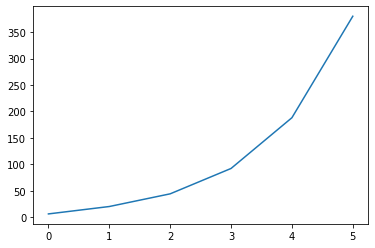

In [968]:
plt.plot(np.arange(6), cx_list)

From these two lists, we can model the number of gates in each list as a function of the number of control

The sequence appears to be piece-wise. 

For $n = 2$,

$$cx_n = 6$$

$$u3_n = 8$$

For $n>2$, 

$$cx_n = 3 \cdot2^{n} - 4$$

$$u3_n = 3 \cdot2^{n} - 2$$



Now on to our pseudo-$CnX$ gate

First, starting with the $C2X$ core.

In [985]:
cx_list = []
u3_list = []

for n in range(2, 9):

    circ = nested_C2X(n)

    a, b = dtp(circ, print_details=False, visual=False, return_values=True)

    cx_list.append(a)
    u3_list.append(b)

In [986]:
cx_list

[3, 5, 7, 9, 11, 13, 15]

In [987]:
u3_list

[4, 8, 12, 16, 20, 24, 28]

We can easily see that starting with $n=2$

$$cx_n = 2n-1$$

$$u3_n = 2n$$

This is a huge improvement compared to the $MCT(n)$ from above

Now onto the $C3X$ core

In [1011]:
cx_list = []
u3_list = []

for n in range(3, 9):

    circ = nested_C3X(n)

    a, b = dtp(circ, print_details=False, visual=False, return_values=True)

    cx_list.append(a)
    u3_list.append(b)

In [1012]:
cx_list

[10, 12, 14, 16, 18, 20]

In [1013]:
u3_list

[13, 17, 21, 25, 29, 33]

Again, the sequence can be easily spotted. Starting with $n=3$,

$$cx_n = 2n+4$$

$$u3_n = 4n+1$$



As of now, we know of no efficient way to create the $C4X$ core, much less $CnX$ core for $n>3$. 

If we did, we would not have to use the pseudo-$CnX$ method anymore. However, looking at the previous two results, one can come up with the postulate that the total number of gate (u3 + cx) to create $C4X$ is $ > 54$

#### Pseudo-C4X Attempt

In [1163]:
# Controlled-T
def CT(n):
    circ = QuantumCircuit(1)
    circ.t(0)
    circ = circ.control(n)
    
    return circ

def CT_dagger(n):
    circ = QuantumCircuit(1)
    circ.tdg(0)
    circ = circ.control(n)
    
    return circ

def CCS(circ, c1, c2, t):
    circ = circ.compose(CT(1), [c2, t])
    circ.cx(c1, c2)
    circ = circ.compose(CT_dagger(1), [c2, t])
    circ.cx(c1, c2)
    circ = circ.compose(CT(1), [c1, t])

    return circ

In [1178]:
def C4X(circ, c1, c2, c3, c4, t):

    circ.ch(c1, t)

    circ = circ.compose(CS(1), [c4, t])

    circ.barrier()

    # circ.ccx(0, 1, 2)
    circ = C2X(circ, c2, c3, c4)

    circ.barrier()

    circ = circ.compose(CS_dagger(1), [c4, t])

    circ.barrier()

    # circ.ccx(0, 1, 2)
    circ = C2X(circ, c2, c3, c4)

    circ.barrier()

    circ = CCS(circ, c2, c3, t)

    circ.barrier()

    circ.ch(c1, t)
    
    return circ

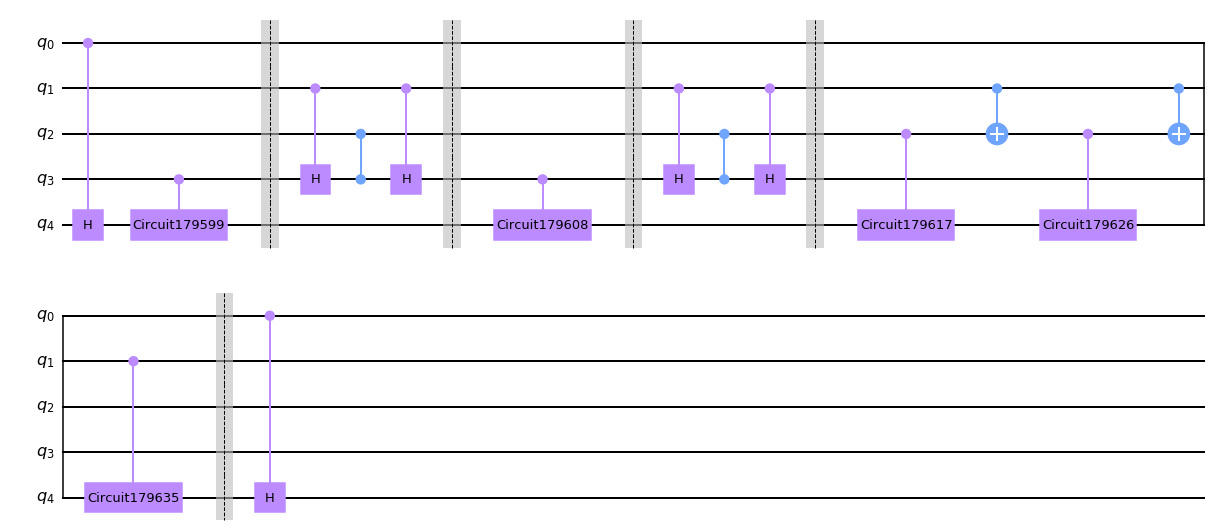

In [1194]:
circ = QuantumCircuit(5)

circ = C4X(circ, 0, 1, 2, 3, 4)

if True:
    milk(circ)

In [1183]:
dtp(circ, visual = False)

cx: 20
u3: 26
Total cost: 226


Improve on the micro-phase, now it's 2*phase

#### Pseudo-C5X

In [1222]:
# Controlled-T
def CP(n, phase):
    circ = QuantumCircuit(1)
    circ.p(phase, 0)
    circ = circ.control(n)
    
    return circ

def CP_dagger(n, phase):
    circ = QuantumCircuit(1)
    circ.p(-phase, 0)
    circ = circ.control(n)
    
    return circ

def CCP(circ, c1, c2, t, phase):
    circ = circ.compose(CP(1, phase), [c2, t])
    circ.cx(c1, c2)
    circ = circ.compose(CP_dagger(1, phase), [c2, t])
    circ.cx(c1, c2)
    circ = circ.compose(CP(1, phase), [c1, t])

    return circ

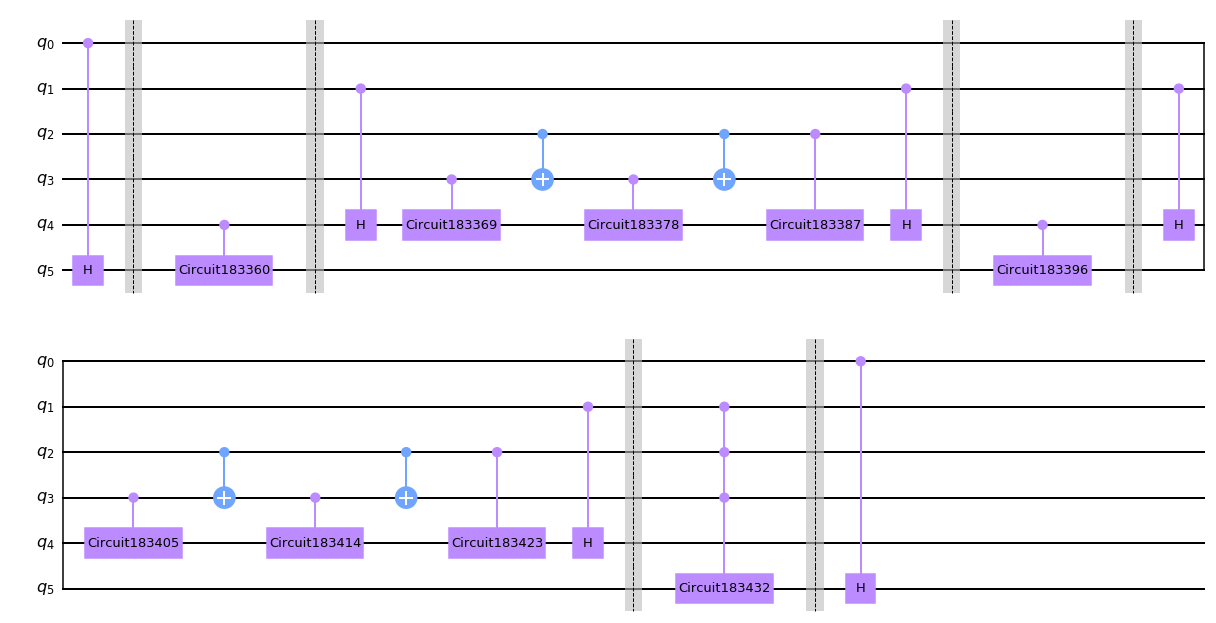

In [1240]:
circ = QuantumCircuit(6)

circ.ch(0, 5)

circ.barrier()

circ = circ.compose(CS(1), [4, 5])

circ.barrier()

# C3X
circ = C3X(circ, 1, 2, 3, 4)

circ.barrier()

circ = circ.compose(CS_dagger(1), [4, 5])

circ.barrier()

# C3X
circ = C3X(circ, 1, 2, 3, 4)

circ.barrier()

# C(n-2)S

circ = circ.compose(CS(3), [1, 2, 3, 5])

circ.barrier()

circ.ch(0, 5)

if True:
    milk(circ)

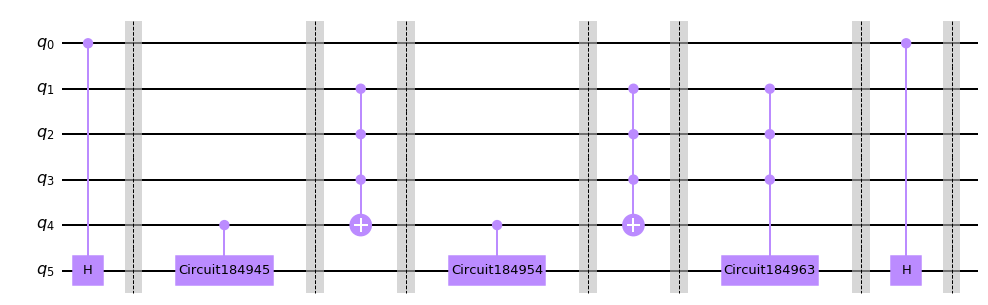

In [1268]:
## Improvement already

circ = QuantumCircuit(n+1)

# CH
circ.ch(0, n)
circ.barrier()

# CS
circ = circ.compose(CS(1), [n-1, n])
circ.barrier()

# CX
circ.mct(list(range(1, n-1)), n-1)
circ.barrier()

# CS_dagger
circ = circ.compose(CS_dagger(1), [n-1, n])
circ.barrier()

# CX
circ.mct(list(range(1, n-1)), n-1)
circ.barrier()

# Final CS
circ = circ.compose(CS(n-2), list(range(1, n-1))+[n])
circ.barrier()

# CH
circ.ch(0, n)
circ.barrier()

if True:
    milk(circ)

In [1266]:
dtp(circ, visual = False)

cx: 66
u3: 75
Total cost: 735
